<a href="https://colab.research.google.com/github/tinahhhhh/Table-Detection/blob/master/Swin_Transformer_Table_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table Detection

This python file is for table detetion task. 

Implemetation steps:

- Install required packages

- Clone my own repo which includes datasets, annotations which created in my local and submodule of mmdetection.

- Load a config file which includes configurations of Faster RCNN architecture with Swin Transformer backbone.

- Modify dataset path and some parameters, and load a checkpoint file.

- Create a model and train dataset.

- Visualize the result.



## Install MMDetection

In [1]:
# Check nvcc version
!nvcc -V #11.0
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install dependencies: (use cu110 because colab has CUDA 11.0)
!pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
#https://pytorch.org/get-started/previous-versions/

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full

# Install Swin-Transformer-Object-Detection
!git clone --recurse-submodules https://github.com/tinahhhhh/Table-Detection.git
%cd Table-Detection/Swin-Transformer-Object-Detection

!pip install -e .

# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow==7.0.0

%cd /content/

In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.7.1+cu110 True
2.11.0
11.0
GCC 7.5


In [ ]:
# install apex
!rm -rf apex
!git clone https://github.com/NVIDIA/apex
!CUDA_HOME=/usr/local/cuda-11.0 pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

#from apex import amp


In [ ]:
!mkdir checkpoints
!wget -c https://github.com/SwinTransformer/storage/releases/download/v1.0.2/mask_rcnn_swin_tiny_patch4_window7.pth \
      -O checkpoints/mask_rcnn_swin_tiny_patch4_window7.pth


In [4]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# Choose to use a config and initialize the detector
config = 'Table-Detection/faster_rcnn_swin_tiny_patch4_window7_mstrain_480-800_coco.py'

# Setup a checkpoint file to load
checkpoint = 'checkpoints/mask_rcnn_swin_tiny_patch4_window7.pth'

# initialize the detector
model = init_detector(config, checkpoint, device='cuda:0')


Use load_from_local loader
The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([4]).
unexpected key in source state_dict: roi_head.mask_head.convs.0.conv.weight, roi_head.mask_head.convs.0.conv.bias, roi_head.mask_head.convs.1.conv.weight, roi_head.mask_head.convs.1.conv.bias, roi_head.mask_head.convs.2.conv.weight, roi_head.mask_head.convs

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [5]:
from mmcv import Config
cfg = Config.fromfile('Table-Detection/faster_rcnn_swin_tiny_patch4_window7_mstrain_480-800_coco.py')


Given a config that trains a Swin Transformer on custom COCO dataset, we need to modify some values to use it for training Swin Transformer.

In [6]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'CocoDataset'
cfg.data_root = 'Table-Detection/TRACKA_training_modern/'
cfg.classes = ('table',)

cfg.data.test.type = 'CocoDataset'
cfg.data.test.data_root = 'Table-Detection/TRACKA_training_modern/'
cfg.data.test.ann_file = 'annotations/test.json'
cfg.data.test.img_prefix = ''
cfg.data.test.classes = cfg.classes

cfg.data.train.type = 'CocoDataset'
cfg.data.train.data_root = 'Table-Detection/TRACKA_training_modern/'
cfg.data.train.ann_file = 'annotations/train.json'
cfg.data.train.img_prefix = ''
cfg.data.train.classes = cfg.classes

cfg.data.val.type = 'CocoDataset'
cfg.data.val.data_root = 'Table-Detection/TRACKA_training_modern/'
cfg.data.val.ann_file = 'annotations/val.json'
cfg.data.val.img_prefix = ''
cfg.data.val.classes = cfg.classes

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 1

# We can still use the pre-trained Swin model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/mask_rcnn_swin_tiny_patch4_window7.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'bbox'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 4
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.runner.max_epochs = 12

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='FasterRCNN',
    pretrained=None,
    backbone=dict(
        type='SwinTransformer',
        embed_dim=96,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        window_size=7,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.2,
        ape=False,
        patch_norm=True,
        out_indices=(0, 1, 2, 3),
        use_checkpoint=False),
    neck=dict(
        type='FPN',
        in_channels=[96, 192, 384, 768],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_st

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [7]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
import mmcv
import os.path as osp

# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector( cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = ('table',)
#print(model.CLASSES)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


2021-05-02 12:56:49,467 - mmdet - INFO - load checkpoint from checkpoints/mask_rcnn_swin_tiny_patch4_window7.pth
2021-05-02 12:56:49,469 - mmdet - INFO - Use load_from_local loader
2021-05-02 12:56:49,610 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([4]).
unexpected key in source state_dict: roi_head.mask_head.con

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale t

2021-05-02 12:56:56,579 - mmdet - INFO - Epoch [1][10/210]	lr: 2.500e-03, eta: 0:29:06, time: 0.696, data_time: 0.244, memory: 4537, loss_rpn_cls: 0.1017, loss_rpn_bbox: 0.0328, loss_cls: 0.4126, acc: 85.1172, loss_bbox: 0.0978, loss: 0.6449
2021-05-02 12:57:00,851 - mmdet - INFO - Epoch [1][20/210]	lr: 2.500e-03, eta: 0:23:23, time: 0.427, data_time: 0.006, memory: 4540, loss_rpn_cls: 0.0347, loss_rpn_bbox: 0.0391, loss_cls: 0.1045, acc: 97.3340, loss_bbox: 0.0926, loss: 0.2709
2021-05-02 12:57:05,360 - mmdet - INFO - Epoch [1][30/210]	lr: 2.500e-03, eta: 0:21:46, time: 0.451, data_time: 0.005, memory: 4540, loss_rpn_cls: 0.0277, loss_rpn_bbox: 0.0688, loss_cls: 0.1089, acc: 96.8750, loss_bbox: 0.1008, loss: 0.3062
2021-05-02 12:57:09,970 - mmdet - INFO - Epoch [1][40/210]	lr: 2.500e-03, eta: 0:21:01, time: 0.461, data_time: 0.006, memory: 4541, loss_rpn_cls: 0.0315, loss_rpn_bbox: 0.0326, loss_cls: 0.0913, acc: 96.7578, loss_bbox: 0.1013, loss: 0.2567
2021-05-02 12:57:14,718 - mmdet 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 120/120, 9.1 task/s, elapsed: 13s, ETA:     0s

2021-05-02 13:03:46,393 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.01s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.808
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.930
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.898
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = -1.000
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.809
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.868
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.868
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.868
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000

2021-05-02 13:03:46,516 - mmdet - INFO - Epoch(val) [4][210]	bbox_mAP: 0.8080, bbox_mAP_50: 0.9300, bbox_mAP_75: 0.8980, bbox_mAP_s: -1.0000, bbox_mAP_m: -1.0000, bbox_mAP_l: 0.8090, bbox_mAP_copypaste: 0.808 0.930 0.898 -1.000 -1.000 0.809
2021-05-02 13:03:53,499 - mmdet - INFO - Epoch [5][10/210]	lr: 2.500e-03, eta: 0:13:25, time: 0.697, data_time: 0.231, memory: 4944, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0168, loss_cls: 0.0325, acc: 98.7012, loss_bbox: 0.0399, loss: 0.0913
2021-05-02 13:03:57,984 - mmdet - INFO - Epoch [5][20/210]	lr: 2.500e-03, eta: 0:13:20, time: 0.448, data_time: 0.005, memory: 4944, loss_rpn_cls: 0.0036, loss_rpn_bbox: 0.0169, loss_cls: 0.0286, acc: 98.7695, loss_bbox: 0.0358, loss: 0.0848
2021-05-02 13:04:02,724 - mmdet - INFO - Epoch [5][30/210]	lr: 2.500e-03, eta: 0:13:15, time: 0.474, data_time: 0.005, memory: 4944, loss_rpn_cls: 0.0035, loss_rpn_bbox: 0.0105, loss_cls: 0.0247, acc: 98.9160, loss_bbox: 0.0389, loss: 0.0776
2021-05-02 13:04:07,539 - mmdet -

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 120/120, 9.2 task/s, elapsed: 13s, ETA:     0s

2021-05-02 13:10:44,785 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...


2021-05-02 13:10:44,924 - mmdet - INFO - Epoch(val) [8][210]	bbox_mAP: 0.7670, bbox_mAP_50: 0.8920, bbox_mAP_75: 0.8590, bbox_mAP_s: -1.0000, bbox_mAP_m: -1.0000, bbox_mAP_l: 0.7850, bbox_mAP_copypaste: 0.767 0.892 0.859 -1.000 -1.000 0.785


DONE (t=0.03s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.767
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.892
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.859
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = -1.000
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.785
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.844
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.844
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.844
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = -1.000
Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.844


2021-05-02 13:10:51,975 - mmdet - INFO - Epoch [9][10/210]	lr: 2.500e-04, eta: 0:06:40, time: 0.704, data_time: 0.232, memory: 4944, loss_rpn_cls: 0.0023, loss_rpn_bbox: 0.0099, loss_cls: 0.0183, acc: 99.3066, loss_bbox: 0.0319, loss: 0.0624
2021-05-02 13:10:56,452 - mmdet - INFO - Epoch [9][20/210]	lr: 2.500e-04, eta: 0:06:35, time: 0.448, data_time: 0.006, memory: 4944, loss_rpn_cls: 0.0033, loss_rpn_bbox: 0.0105, loss_cls: 0.0260, acc: 98.8672, loss_bbox: 0.0346, loss: 0.0744
2021-05-02 13:11:01,046 - mmdet - INFO - Epoch [9][30/210]	lr: 2.500e-04, eta: 0:06:30, time: 0.459, data_time: 0.005, memory: 4944, loss_rpn_cls: 0.0037, loss_rpn_bbox: 0.0140, loss_cls: 0.0240, acc: 99.0137, loss_bbox: 0.0384, loss: 0.0802
2021-05-02 13:11:05,841 - mmdet - INFO - Epoch [9][40/210]	lr: 2.500e-04, eta: 0:06:25, time: 0.479, data_time: 0.006, memory: 4944, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0104, loss_cls: 0.0178, acc: 99.2285, loss_bbox: 0.0252, loss: 0.0554
2021-05-02 13:11:10,810 - mmdet 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 120/120, 9.1 task/s, elapsed: 13s, ETA:     0s

2021-05-02 13:17:44,141 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.01s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.855
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.931
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.921
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = -1.000
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.858
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.895
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.895
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.895
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000

2021-05-02 13:17:44,270 - mmdet - INFO - Epoch(val) [12][210]	bbox_mAP: 0.8550, bbox_mAP_50: 0.9310, bbox_mAP_75: 0.9210, bbox_mAP_s: -1.0000, bbox_mAP_m: -1.0000, bbox_mAP_l: 0.8580, bbox_mAP_copypaste: 0.855 0.931 0.921 -1.000 -1.000 0.858


## Test the trained detector

After finetuning the detector, let's visualize the prediction results!

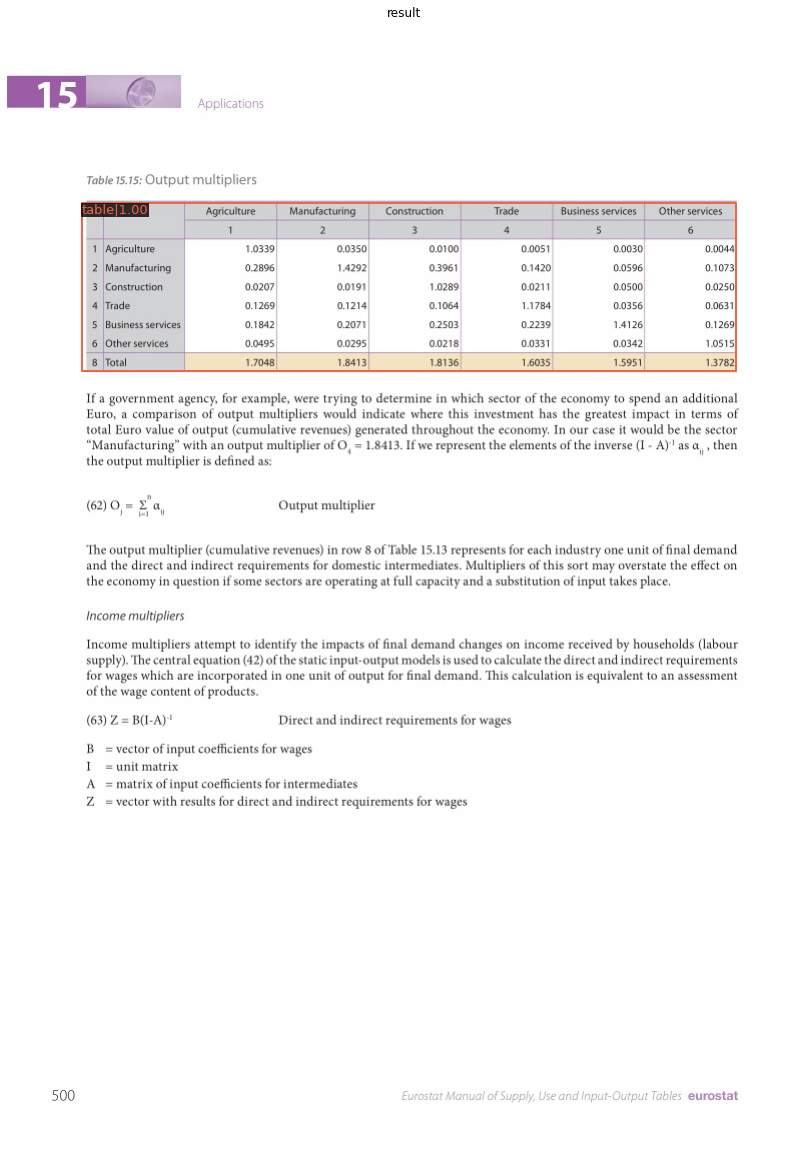

In [9]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

img = mmcv.imread('Table-Detection/TRACKA_training_modern/cTDaR_t10490.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)
